In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model, metrics, tree, ensemble, preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample

# Final Project - Loan Approval Prediction Model

### <u>**Business Context**</u>
Loan approval is a critical process for financial institutions. Each application must be evaluated to decide whether to approve or reject the borrower, based on criteria such as income, employment, credit history, and other attributes. Traditionally, these decisions are made by loan officers following policy guidelines, but manual process can be slow, inconsistent, and prone to human bias.

Machine Learning (ML) offers an opportunity to **automate and standardize loan approval decisions**, making the process faster, more consistent, and scalable. By learning from past approval data, ML models can identify patterns in the applicant profiles that led to approvals or rejections.

However, it is important to note that in this dataset, the target variable (`loan_status`) only indicates whether an application was **approved or rejected**, not whether an approved borrower later **repaid successfully or defaulted**. Therefore, the model predicts the likelihood of approval based on past decisions — essentially capturing the institution's historical lending policy.

### <u>**Problem Statement**</u>
The objective of this project is to build and evaluate ML models that can **predict whether a loan application will be approved or rejected**, given applicant information.

Key goals:
- Develop a classification model that replicates past approval patterns.
- Compare different algorithms (Logistic Regression, Decission Tree, Random Forest) to find the most accurate and robust model)

This project does not predict repayment or default risk. Future improvements could integrate those repayment outcomes, allowing the model to optimize for **financial performance (minimizing defaults/losses)** rather than only mimicking approval history.

### <u>**Data Preparation & EDA**</u>

In [2]:
df = pd.read_csv("loan_approval_dataset.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


In [4]:
df = df.drop(columns=["loan_id"])

In [5]:
df.sample(5)

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
29,3,Not Graduate,Yes,9000000,31500000,10,850,21800000,12400000,33700000,8000000,Approved
344,0,Graduate,No,2600000,5100000,14,678,500000,1200000,6000000,3100000,Approved
2253,0,Graduate,Yes,2300000,7900000,10,430,6600000,2800000,8100000,1900000,Rejected
1180,0,Graduate,No,3900000,14500000,8,545,5900000,3000000,10300000,3400000,Rejected
1292,4,Graduate,No,8000000,31500000,18,683,10300000,7900000,30100000,9600000,Approved


#### Check for missing data

In [6]:
df.isna().sum()

no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

#### Check for duplicate

In [7]:
df.duplicated().sum()

np.int64(0)

#### Check columns and their values

In [8]:
df.columns

Index([' no_of_dependents', ' education', ' self_employed', ' income_annum',
       ' loan_amount', ' loan_term', ' cibil_score',
       ' residential_assets_value', ' commercial_assets_value',
       ' luxury_assets_value', ' bank_asset_value', ' loan_status'],
      dtype='object')

In [9]:
df.columns = df.columns.str.strip()

In [10]:
df.describe()

,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
count,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03
mean,2.498712,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06
std,1.695910,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06
min,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00
25%,1.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06
50%,3.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06
75%,4.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06
max,5.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07


In [11]:
print("education:", df["education"].unique())
print("self_employed:", df["self_employed"].unique())
print("loan_status:", df["loan_status"].unique())

education: [' Graduate' ' Not Graduate']
self_employed: [' No' ' Yes']
loan_status: [' Approved' ' Rejected']


In [12]:
# Clean whitespace from object value
df_obj_col = df.select_dtypes(include=["object"]).columns
df[df_obj_col] = df[df_obj_col].apply(lambda x: x.str.strip())

In [13]:
# Map target column to binary
df["loan_status"] = df["loan_status"].map({"Rejected": 0, "Approved": 1})

In [14]:
# split feature based on data type
target_col = "loan_status"
df_num = df.select_dtypes(include=["int64"]).drop(columns=[target_col])
df_num_col = df_num.columns
df_obj = df.select_dtypes(include=["object"])
df_obj_col = df_obj.columns

#### Check features distribution plot

In [15]:
print(f"numeric columns: {len(df_num_col)}")

numeric columns: 9


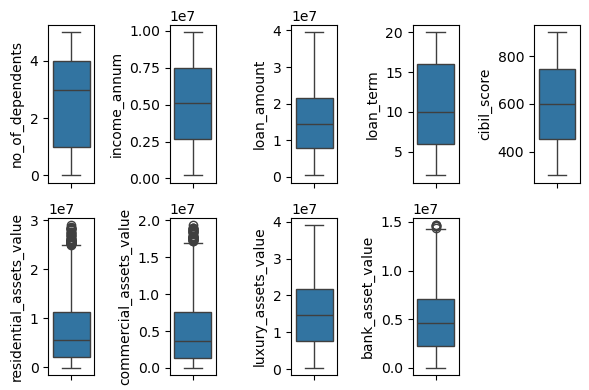

In [16]:
# Box plot
plt.figure(figsize=(6,4))
for i in range(len(df_num_col)):
    plt.subplot(2, 5, i+1)
    sns.boxplot(df[df_num_col[i]], orient="v")
    plt.tight_layout()

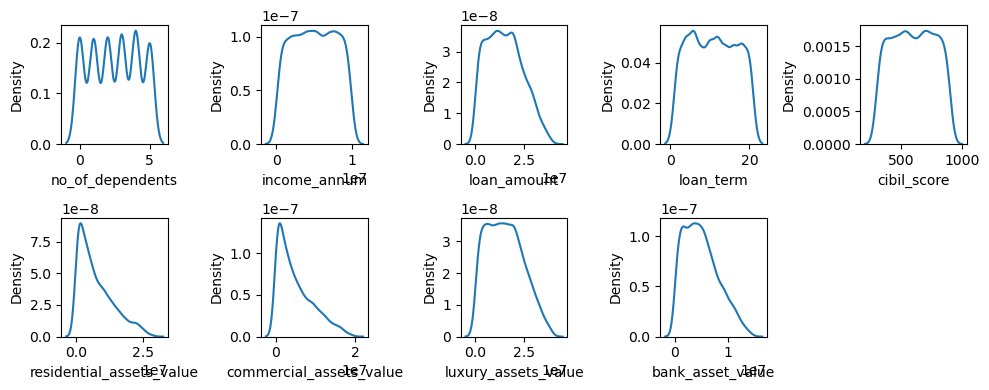

In [17]:
# KDE plot
plt.figure(figsize=(10,4))
for i in range(len(df_num_col)):
    plt.subplot(2, 5, i+1)
    sns.kdeplot(df[df_num_col[i]])
    plt.tight_layout()

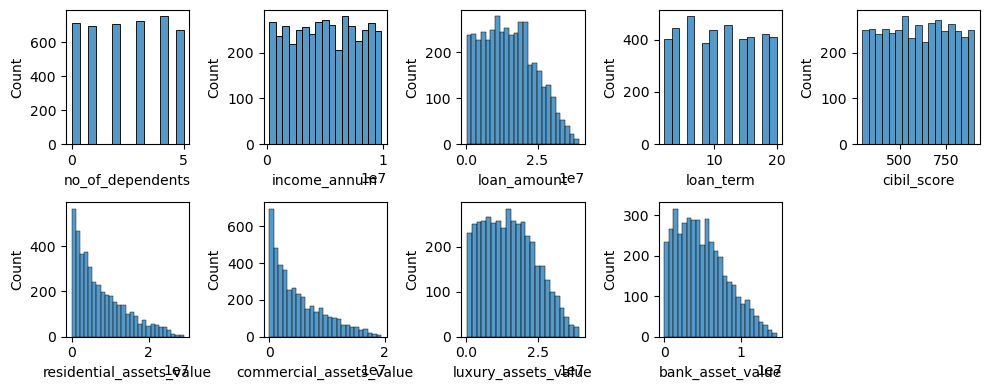

In [18]:
# Histogram plot
plt.figure(figsize=(10, 4))
for i in range(len(df_num_col)):
    plt.subplot(2, 5, i+1)
    sns.histplot(df[df_num_col[i]])
    plt.tight_layout()

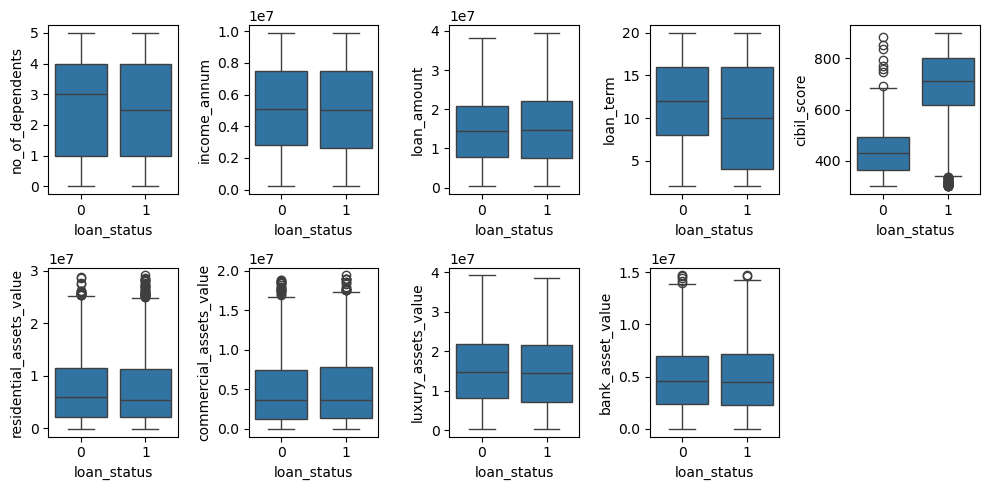

In [19]:
plt.figure(figsize=(10,5))
for i in range(len(df_num_col)):
    plt.subplot(2, 5, i+1)
    sns.boxplot(x=target_col, y=df_num_col[i], data=df)
    plt.tight_layout()

#### Feature-Target Relationship Analysis

In [20]:
from scipy.stats import pointbiserialr, chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

# 1. Point-Biserial Correlation (numeric vs binary target)
pb_results = []
for col in df_num_col:
    corr, pval = pointbiserialr(df[col], df[target_col])
    pb_results.append({"Feature": col, "Score": abs(corr), "Test": "Point-Biserial"})

# 2. Chi-Square Test (Categorical vs binary target)
chi_results = []
for col in df_obj_col:
    contingency = pd.crosstab(df[col], df[target_col])
    chi2, p, dof, ex = chi2_contingency(contingency)
    chi_results.append({"Feature": col, "Score": chi2, "Test": "Chi-square"})

# 3. Mutual Information (general relevance)
# Encode categorical features
df_encoded = df.copy()
for col in df_obj_col:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]
mi_scores = mutual_info_classif(X, y, discrete_features="auto", random_state=42)

mi_results = [{"Feature": col, "Score": mi, "Test": "Mutual Info"}
              for col, mi in zip(X.columns, mi_scores)]

# Combine all results
score_df = pd.DataFrame(pb_results + chi_results + mi_results)
score_filter_df = score_df[score_df["Score"] > 0.00000001]

# Rank by score within each test
score_result_df = score_filter_df.sort_values(by=["Test", "Score"], ascending=[True, False]).reset_index(drop=True)
score_result_df

,Feature,Score,Test
0,education,0.083958,Chi-square
1,cibil_score,0.507937,Mutual Info
2,loan_term,0.018156,Mutual Info
3,education,0.007088,Mutual Info
4,luxury_assets_value,0.006186,Mutual Info
5,self_employed,0.000630,Mutual Info
6,cibil_score,0.770518,Point-Biserial
7,loan_term,0.113036,Point-Biserial
8,no_of_dependents,0.018114,Point-Biserial
9,loan_amount,0.016150,Point-Biserial


**<u>Insight</u>**
<br>
Analysis across three statistical measures (Point-Biserial correlation, Mutual Information, and Chi-square) shows that `cibil_score` is by far the dominant predictor of loan approval, with strong correlation (**r ≈ 0.77**) and high mutual information (**MI ≈ 0.51**).
`loan_term` shows a smaller but noticeable relationship with approval outcomes — shorter loan terms tend to be approved more often.
<br>
Other features, such as `education`, `income_annum`, `asset values`, etc. show negligible predictive power in this dataset and can be deprioritized in the initial model design.
Meanwhile, the rest of the features not displayed on the table above show scores close to zero, indicating they have essentially no relationship or effect on the approval decision and can be deprioritized in the model design.

#### Check for outliers

In [21]:
for col in df_num_col:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}: {len(outliers)} outliers")

no_of_dependents: 0 outliers
income_annum: 0 outliers
loan_amount: 0 outliers
loan_term: 0 outliers
cibil_score: 0 outliers
residential_assets_value: 52 outliers
commercial_assets_value: 37 outliers
luxury_assets_value: 0 outliers
bank_asset_value: 5 outliers


Outlier analysis using the IQR method identified some extreme values in 3 features: `residential_assets_value`, `luxury_assets_value`, and `bank_asset_value`. However, these points are not isolated anomalies; they fall within the natural long tails of the distribution. This suggests that the dataset is **skewed** rather than containing erroneous records. Therefore, the outliers likely represent valid high-value cases and will be retained for modeling.

### <u>**Data/Feature Pre-processing**</u>

#### Feature Scaling

In [22]:
# Standardize all numeric features by using mean scaling
scaler = preprocessing.RobustScaler()
scaled_features = scaler.fit_transform(df_num)
df_num_scaled = pd.DataFrame(scaled_features, index=df_num.index, columns=df_num_col)
df_num_scaled.sample(5)

,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
140,-0.333333,-0.541667,-0.369565,0.0,0.430508,0.109890,0.063492,-0.359155,-0.270833
3110,-1.000000,-0.916667,-0.920290,0.2,-0.677966,-0.450549,-0.412698,-0.873239,-0.895833
2325,-1.000000,-0.833333,-0.739130,0.8,0.772881,-0.538462,-0.460317,-0.823944,-0.770833
4095,-0.666667,0.020833,0.434783,0.0,-0.654237,-0.494505,-0.047619,0.253521,-0.166667
1345,-0.666667,-0.812500,-0.804348,1.0,0.396610,-0.274725,-0.349206,-0.852113,-0.770833


We chose RobustScaler for scaling the numeric features to handle skewed distributions and outliers.

#### One Hot Encoding

In [23]:
# Recombine the splitted features (numerical, categorical, and target)
df_scaled = pd.concat([df_num_scaled, df_obj, df[target_col]], axis=1)

# One hot encoding on the categorical column
obj_col = list(df_obj_col)
df_final = pd.get_dummies(df_scaled, columns=obj_col)
df_final.sample(5)

,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status,education_Graduate,education_Not Graduate,self_employed_No,self_employed_Yes
1941,-0.333333,-0.979167,-0.956522,0.6,-0.315254,-0.593407,-0.555556,-0.922535,-0.895833,0,True,False,True,False
1058,0.000000,-0.437500,-0.224638,0.0,-0.596610,-0.417582,0.079365,-0.260563,-0.645833,0,False,True,False,True
995,0.333333,-0.562500,-0.688406,-0.6,0.393220,-0.450549,-0.142857,-0.542254,-0.666667,1,False,True,True,False
3114,0.333333,-0.833333,-0.789855,-0.2,0.315254,-0.351648,-0.380952,-0.760563,-0.645833,1,True,False,True,False
2525,0.666667,-0.250000,-0.449275,0.8,0.000000,-0.186813,-0.492063,-0.295775,0.208333,1,False,True,False,True


#### Train Test Splitting

In [24]:
y = df_final["loan_status"]
X = df_final.drop(columns=["loan_status"])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2988, 13)
(1281, 13)
(2988,)
(1281,)


In [27]:
y_train.value_counts()

loan_status
1    1859
0    1129
Name: count, dtype: int64

The target variable / label `loan_status` has the following distribution:
<br>
- `Approved (1)`: 1,859 records (60%)
- `Rejected (0)`: 1,129 records (40%)


This indicates a mild imbalance (60 : 40 ratio). Such a distribution is not considered highly imbalanced, so we do not expect it to significantly bias our models. Therefore, we will proceed with the training data without applying resampling techniques.

### <u>**Modeling**</u>

#### Logistic Regression

In [28]:
log_reg = linear_model.LogisticRegression()
log_reg = log_reg.fit(X_train, y_train)

#### Decision Tree

In [29]:
dec_tree = tree.DecisionTreeClassifier()
dec_tree = dec_tree.fit(X_train, y_train)

#### Random Forest

In [30]:
rand_forest_tuning = ensemble.RandomForestClassifier(random_state=42, n_jobs=-1)

# Hyperparameter tuning
params = {
    "max_depth": [2, 3, 5, 10],
    "min_samples_leaf": [5, 10, 20, 50, 100],
    "n_estimators": [10, 25, 30, 50, 100]
}

# Instantiate grid search model
grid_search = GridSearchCV(estimator=rand_forest_tuning,
                           param_grid=params,
                           cv=4,
                           n_jobs=-1,
                           verbose=1,
                           scoring="roc_auc")

grid_search.fit(X_train,y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'n_estimators': [10, 25, 30, 50, 100]},
             scoring='roc_auc', verbose=1)

In [31]:
grid_search.best_score_

np.float64(0.9966955525403647)

In [32]:
rand_forest = grid_search.best_estimator_
rand_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=20, n_jobs=-1,
                       random_state=42)

### <u>**Evaluation**</u>

In [33]:
# Model prediction
log_reg_pred = log_reg.predict(X_test)
dec_tree_pred = dec_tree.predict(X_test)
rand_forest_pred = rand_forest.predict(X_test)

#### Accuracy Score

In [34]:
print("Logistic Regression: ", metrics.accuracy_score(y_test, log_reg_pred))
print("Decission Tree: ", metrics.accuracy_score(y_test, dec_tree_pred))
print("Random Forest: ", metrics.accuracy_score(y_test, rand_forest_pred))

Logistic Regression:  0.9234972677595629
Decission Tree:  0.9711163153786104
Random Forest:  0.970335675253708


#### Precision Score

In [35]:
print("Logistic Regression: ", metrics.precision_score(y_test, log_reg_pred, pos_label=1, average="binary"))
print("Decission Tree: ", metrics.precision_score(y_test, dec_tree_pred, pos_label=1, average="binary"))
print("Random Forest: ", metrics.precision_score(y_test, rand_forest_pred, pos_label=1, average="binary"))

Logistic Regression:  0.9374217772215269
Decission Tree:  0.9834605597964376
Random Forest:  0.9973787680209698


#### Recall Score

In [36]:
print("Logistic Regression: ", metrics.recall_score(y_test, log_reg_pred, pos_label=1, average="binary"))
print("Decission Tree: ", metrics.recall_score(y_test, dec_tree_pred, pos_label=1, average="binary"))
print("Random Forest: ", metrics.recall_score(y_test, rand_forest_pred, pos_label=1, average="binary"))

Logistic Regression:  0.9397741530740276
Decission Tree:  0.9698870765370138
Random Forest:  0.9548306148055207


#### ROC AUC Score

In [37]:
log_reg_prob = log_reg.predict_proba(X_test)[:, 1]
dec_tree_prob = dec_tree.predict_proba(X_test)[:, 1]
rand_forest_prob = rand_forest.predict_proba(X_test)[:, 1]

print("Logistic Regression: ", metrics.roc_auc_score(y_test, log_reg_prob))
print("Decission Tree: ", metrics.roc_auc_score(y_test, dec_tree_prob))
print("Random Forest: ", metrics.roc_auc_score(y_test, rand_forest_prob))

Logistic Regression:  0.9717535800574468
Decission Tree:  0.9715137862023913
Random Forest:  0.9984834658896482


#### Classification Report

In [38]:
print("Logistic Regression: \n", metrics.classification_report(y_test, log_reg_pred))
print("Decission Tree: \n", metrics.classification_report(y_test, dec_tree_pred))
print("Random Forest: \n", metrics.classification_report(y_test, rand_forest_pred))

Logistic Regression: 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       484
           1       0.94      0.94      0.94       797

    accuracy                           0.92      1281
   macro avg       0.92      0.92      0.92      1281
weighted avg       0.92      0.92      0.92      1281

Decission Tree: 
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       484
           1       0.98      0.97      0.98       797

    accuracy                           0.97      1281
   macro avg       0.97      0.97      0.97      1281
weighted avg       0.97      0.97      0.97      1281

Random Forest: 
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       484
           1       1.00      0.95      0.98       797

    accuracy                           0.97      1281
   macro avg       0.96      0.98      0.97      1281
weighted avg    

### <u>**Conclusion**</u>

**Random Forest** is the strongest candidate for **loan approval prediction**, outperforming Logistic Regression and Decision Tree. 
<br>
It achieves the **highest ROC AUC score**, with **almost perfect precision (0.9974)** and **high recall (0.9548**) for the positive class (Approved). This means:
1. **Precision ≈ 1.0**: If the model predicts "Approved", it almost always matches the historical approval decision.
2. **Recall ≈ 0.95**: Out of 100 historically approved applicants, the model correctly identifies about 95 of them as "Approved"

In plain terms, the model **closely replicates past approval patterns** while avoiding misclassifying previously rejected applicants.

#### Business Implication
For the bank, this model provides a reliable way to **automate and standardize** the approval decision process:
- Nearly every applicant the model "approves" would also have been approved by loan officers in the past (high precision)
- About 95% of applicants historically approved are still approved by the model (high recall), meaning minimal loss of potential business.

This ensures **efficiency, consistency, and fairness** in processing applications. The small trade-off is that ~5% of historically approved applicants may now be flagged as rejected, but this is acceptable if the bank prioritizes consistent, automated decision-making.

### <u>**Limitation and Future Improvements**</u>

#### Limitation:
- **Approval Bias Replication:**
  <br>
  The model only learns from past approval decisions. If historical approvals contained bias (e.g., towards/against certain demographics, job types, or income levels), the model will replicate and reinforce those biases.
- **No Default Information:**
  <br>
  The dataset only tracks approval/rejection decisions, not whether borrowers repaid or defaulted. Thus, the model cannot evaluate financial risk or creditworthiness. It only mimics past approval patterns.

#### Future Improvements:
- **Integrate Repayment Outcomes:**
  <br>
  By including repayment/default data, the model could predict not just who *gets approved*, but also who is *likely to repay successfully*. This could directly minimize default rates and losses.
- **Model Calibration:**
  <br>
  Fine-tune the decision threshold to balance approval rate, depending on the bank's strategy.